## Setup

In [2]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
keras = tf.keras

2.15.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

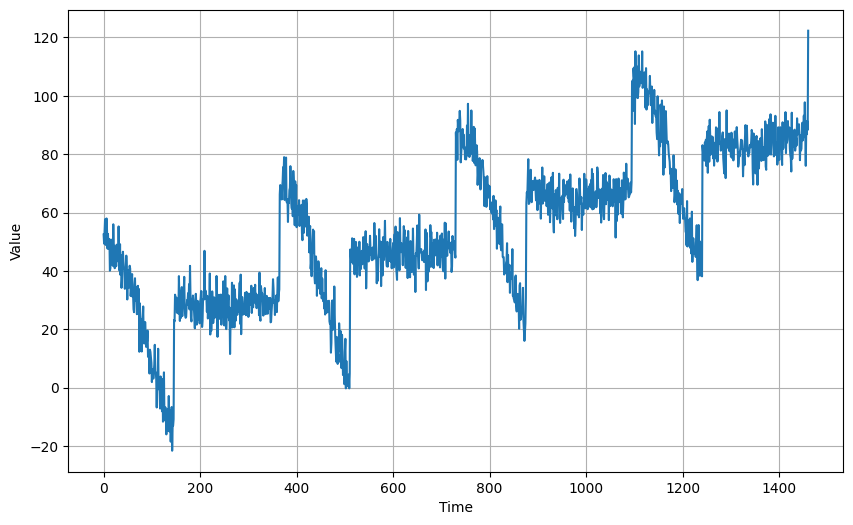

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 10s 93ms/step - loss: 62.2825 - mae: 62.7823 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 4s 107ms/step - loss: 54.2672 - mae: 54.7672 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 3s 75ms/step - loss: 45.9447 - mae: 46.4445 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 3s 78ms/step - loss: 38.7603 - mae: 39.2601 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 2s 68ms/step - loss: 32.0148 - mae: 32.5103 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 2s 58ms/step - loss: 27.6403 - mae: 28.1359 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 39ms/step - loss: 24.2516 - mae: 24.7505 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 42ms/step - loss: 22.6703 - mae: 23.1678 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 39ms/step - loss: 21.4316 - ma

(1e-08, 0.0001, 0.0, 30.0)

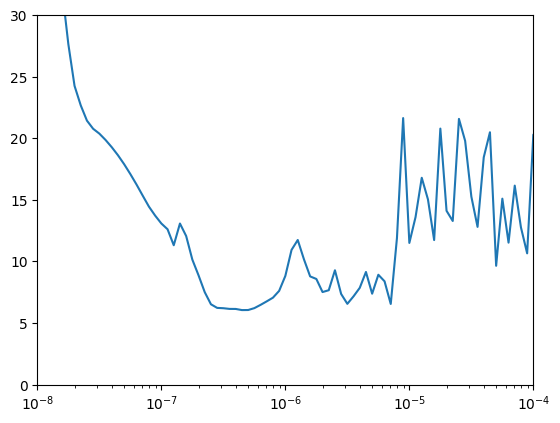

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 6s 77ms/step - loss: 8110.2217 - mae: 8110.7207 - val_loss: 783.3560 - val_mae: 783.8559


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
33/33 [==============================] - 3s 78ms/step - loss: 6075.6455 - mae: 6076.1450 - val_loss: 3347.4919 - val_mae: 3347.9917
Epoch 3/500
33/33 [==============================] - 2s 60ms/step - loss: 5179.6636 - mae: 5180.1636 - val_loss: 9242.4502 - val_mae: 9242.9502
Epoch 4/500
33/33 [==============================] - 2s 52ms/step - loss: 8685.9121 - mae: 8686.4121 - val_loss: 8212.6191 - val_mae: 8213.1191
Epoch 5/500
33/33 [==============================] - 2s 49ms/step - loss: 3162.0532 - mae: 3162.5527 - val_loss: 22.9857 - val_mae: 23.4838
Epoch 6/500
33/33 [==============================] - 3s 89ms/step - loss: 8208.3887 - mae: 8208.8867 - val_loss: 26141.7871 - val_mae: 26142.2871
Epoch 7/500
33/33 [==============================] - 2s 49ms/step - loss: 9693.3193 - mae: 9693.8193 - val_loss: 14360.9443 - val_mae: 14361.4443
Epoch 8/500
33/33 [==============================] - 2s 50ms/step - loss: 7880.6519 - mae: 7881.1533 - val_loss: 7217.0234 - val_mae: 72

In [11]:
model = keras.models.load_model("my_checkpoint.h5")

In [12]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 1s/step


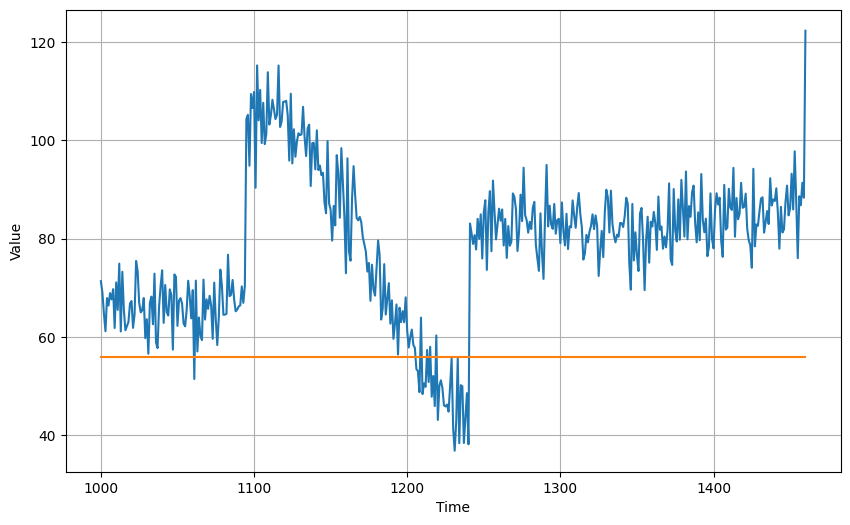

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

23.73688